In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import numpy as np
import time
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
scaler = preprocessing.MinMaxScaler()


In [2]:
def time_ms():
    return round(time.time()*1000)

def clean_column_ids(df, col):
    return df[col].map(lambda x: x.split("|")[1])

def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)

In [3]:
def read_score(path):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,2,4,5,6], header=None)
    df.columns = ["sequence", "reference", "eval", "score", "bias"]
    df.sort_values(by=["score"], inplace=True, ascending=False)
    df["sequence"] = clean_column_ids(df, "sequence")
    df.set_index("sequence", inplace=True)
    return df
def read_family(path):
    df = None
    try:
        df = pd.read_csv(path, delimiter=r"\s+", comment="#", usecols=[0,2,4,5,6,17], header=None)
    except pd.errors.EmptyDataError:
        return pd.DataFrame(columns=["family", "seq", "f_eval", "f_score", "f_bias", "n_dom"])
    df.columns = ["family", "seq", "f_eval", "f_score", "f_bias", "n_dom"]
    df["seq"] = clean_column_ids(df, "seq")
    #df.drop_duplicates(subset=["seq"], keep="first", inplace=True)
    df.set_index("seq", inplace=True)
    return df
def read_len(path):
    db_fasta = ""
    with open(path, "r") as f:
        db_fasta = ("\n" + f.read()).split("\n>")[1:]
    a = []
    for protein_fasta in db_fasta:
        id, seq = parse_fasta(protein_fasta)
        id = id.split("|")[1]
        a.append((id, seq, len(seq)))
    return pd.DataFrame(a, columns=["seq", "str", "seqlen"]).set_index("seq").rename_axis(index=None)
    

In [70]:
def splot(df, x, y, hue=None, legend=True, ylog=False):
    f, ax = plt.subplots(figsize=(6.5,6.5))
    sb.set_theme(style="whitegrid")
    if ylog:
        ax.set(yscale="log")
    sb.scatterplot(x=x, y=y, hue=hue, ax=ax, data=df)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if ax.get_legend() and not legend:
        ax.get_legend().remove()

In [91]:
def load_all(path, normalise=False):
    hmms_files = sorted(glob.glob(path.replace("$$$", "hmmsearch")))
    phmm_files = sorted(glob.glob(path.replace("$$$", "phmmer")))
    fasta_files = sorted(glob.glob(path.replace("$$$", "clean").replace(".out", ".clean.fasta")))
    dfs = []
    files = list(zip(hmms_files, phmm_files, fasta_files))
    for file in files:
        ref = file[0].split("/")[-1].split(".")[0]
        hmms_df = read_score(file[0]).rename(columns={"score" : "hmms_score", "eval" : "hmms_eval", "bias" : "hmms_bias"})
        phmm_df = read_score(file[1]).rename(columns={"score" : "phmm_score", "eval" : "phmm_eval", "bias" : "phmm_bias"})
        phmm_df.drop(["reference"], axis=1, inplace=True)
        len_df = read_len(file[2])
        df = pd.concat([hmms_df, phmm_df, len_df], axis=1)
        if normalise:
            df["phmm_score"] = scaler.fit_transform(df["phmm_score"].values.reshape(-1,1))
            df["hmms_score"] = scaler.fit_transform(df["hmms_score"].values.reshape(-1,1))
        dfs.append(df)
    frame = pd.concat(dfs, axis=0)
    return frame


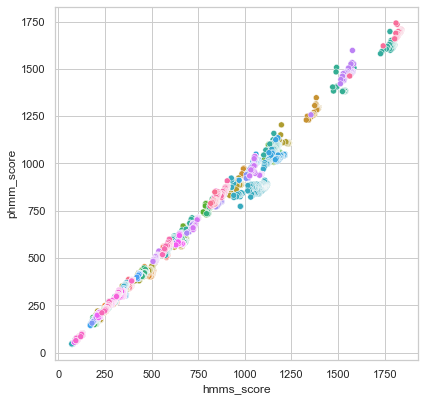

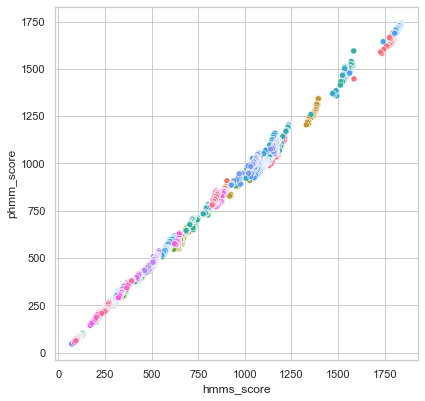

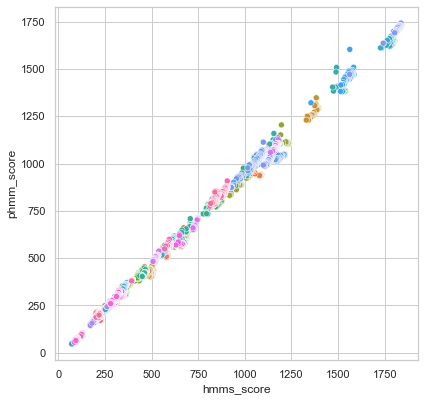

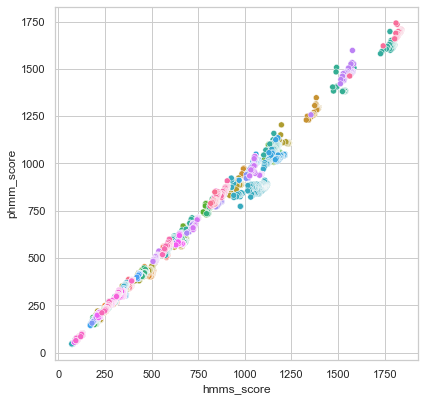

In [92]:
df90 = load_all("./../out/uniprot_sprot.90.multi-step/$$$/*.out")
ide90 = load_all("./../out/uniprot_sprot.90.id.multi-step/$$$/*.out")
hl90 = load_all("./../out/uniprot_sprot.90.hl.multi-step/$$$/*.out")
sim90 = load_all("./../out/uniprot_sprot.90.s.multi-step/$$$/*.out")
splot(df90, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(ide90, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(hl90, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(sim90, "hmms_score", "phmm_score", hue="reference", legend=False)

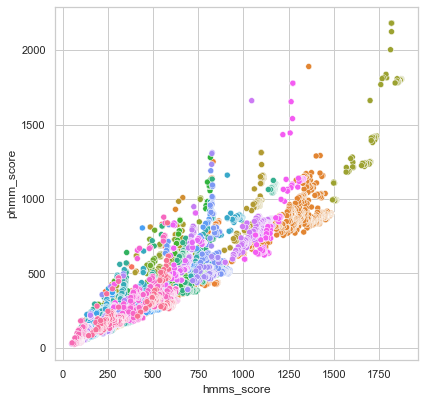

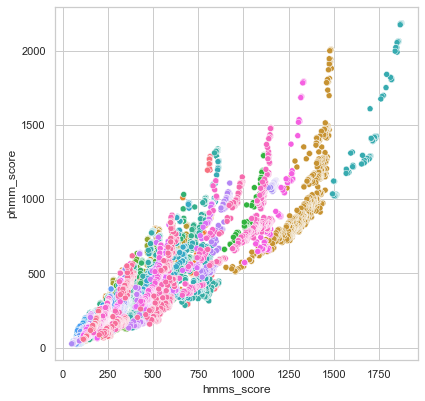

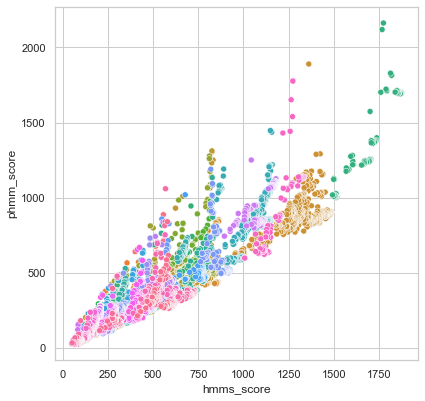

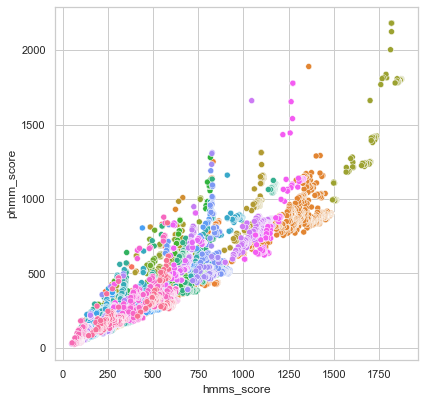

In [93]:
df40 = load_all("./../out/uniprot_sprot.40.multi-step/$$$/*.out")
ide40 = load_all("./../out/uniprot_sprot.40.id.multi-step/$$$/*.out")
hl40 = load_all("./../out/uniprot_sprot.40.hl.multi-step/$$$/*.out")
sim40 = load_all("./../out/uniprot_sprot.40.s.multi-step/$$$/*.out")
splot(df40, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(ide40, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(hl40, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(sim40, "hmms_score", "phmm_score", hue="reference", legend=False)

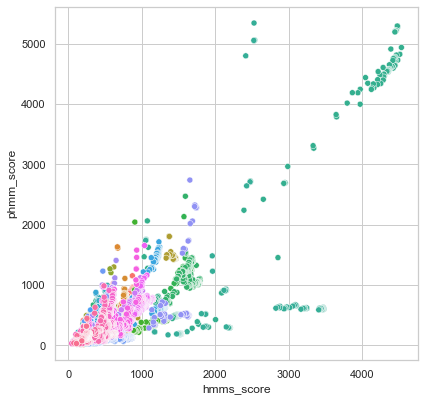

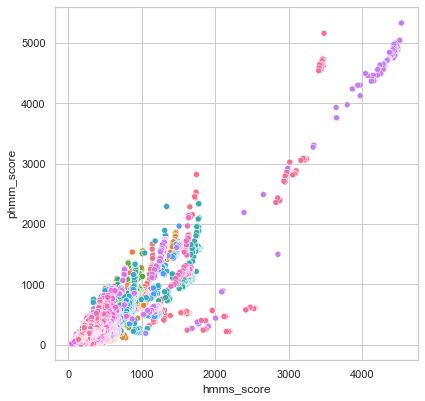

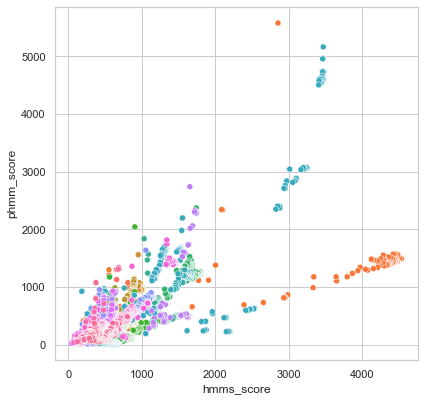

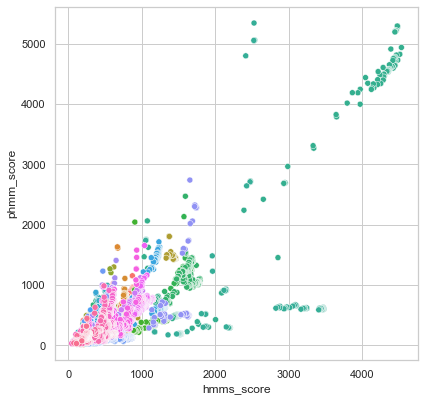

In [94]:
df20 = load_all("./../out/uniprot_sprot.20.multi-step/$$$/*.out")
ide20 = load_all("./../out/uniprot_sprot.20.id.multi-step/$$$/*.out")
hl20 = load_all("./../out/uniprot_sprot.20.hl.multi-step/$$$/*.out")
sim20 = load_all("./../out/uniprot_sprot.20.s.multi-step/$$$/*.out")
splot(df20, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(ide20, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(hl20, "hmms_score", "phmm_score", hue="reference", legend=False)
splot(sim20, "hmms_score", "phmm_score", hue="reference", legend=False)

(22480, 9)
(22480, 9)
(22480, 9)
(22480, 9)
